# Download

In [1]:
WORKING_ENV = 'COLAB' # Can be LABS, COLAB or PAPERSPACE
assert WORKING_ENV in ['LABS', 'COLAB', 'LOCAL']

import sys
import os
if WORKING_ENV == 'COLAB':
  from google.colab import drive
  drive.mount('/content/drive/')
  !pip install medmnist
  !pip install torch
  !pip install gputil
  !pip install psutil
  !pip install humanize
  ROOT = "/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/"
  sys.path.append(ROOT + "./attention_masking_moco/")
  !nvidia-smi
  slurm_id = 0
elif WORKING_ENV == 'LABS':
  ROOT = "/vol/bitbucket/sx119/Contrastive-Medical-Image-Classification/"
  slurm_id = os.environ["SLURM_JOB_ID"]
else:
  ROOT = "/Users/xushitong/Contrastive-Medical-Image-Classification/"
  slurm_id = 0

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=5d2db6488c04604102152eaeffa0b3197d529971984c65e912873560e6dcb54d
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=2f0ba0ae53d02fec2f5cd9f921e94444ed93cd57135efd38571f61b74567061e
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee3182

# Import

In [2]:
import medmnist

import argparse
import math
import random
import shutil
import time
import tqdm
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
# import torch.distributed as dist
import torch.optim
import torch.utils.data
# import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.models as models

import loader
import builder

import numpy as np

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("using device: ", dev)


using device:  cuda:0


In [3]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 12.3 GB
GPU 0 ... Mem Free: 15098MB / 15360MB | Utilization   0%


# Hyperparameters

In [30]:
EPOCH_NUM = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.03
MOMENTUM = 0.9 # momentum of SGD
MOCO_MOMENTUM = 0.999 # momentum of moco
LOSS_TYPE = "self"
# LOSS_TYPE = "cate-ce"
# LOSS_TYPE = "binary-ce"
TRAIN_SET_RATIO = 0.9
MOCO_V2 = True
# ATTENTION_INFO = ("crop", 96, 96)
ATTENTION_INFO = ("mask", 8, 8)
PROJ_HEAD_EPOCH_NUM = 20

trial_name = f"epochs{EPOCH_NUM}_batch{BATCH_SIZE}_lr{LEARNING_RATE}_momentum{MOMENTUM}_moco-momentum{MOCO_MOMENTUM}_loss-type{LOSS_TYPE}_V2{MOCO_V2}_att-info{'-'.join([str(x) for x in ATTENTION_INFO])}"
arg_command = \
f"--epochs_{EPOCH_NUM}_-b_{BATCH_SIZE}_--lr_{LEARNING_RATE}_--momentum_{MOMENTUM}_--moco-m_{MOCO_MOMENTUM}_--print-freq_100\
_--loss-type_{LOSS_TYPE}_{'' if WORKING_ENV == 'LOCAL' else '--gpu_0_'}{'--mlp_--aug-plus_--cos_' if MOCO_V2 else ''}{ROOT}./datasets".split("_")

print(f"Running command {arg_command}")

Running command ['--epochs', '20', '-b', '128', '--lr', '0.03', '--momentum', '0.9', '--moco-m', '0.999', '--print-freq', '100', '--loss-type', 'self', '--gpu', '0', '--mlp', '--aug-plus', '--cos', '/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/./datasets']


In [5]:
#!/usr/bin/env python
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet50',
                    choices=model_names,
                    help='model architecture: ' +
                        ' | '.join(model_names) +
                        ' (default: resnet50)')
# parser.add_argument('-j', '--workers', default=32, type=int, metavar='N',
#                     help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=0.03, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int,
                    help='learning rate schedule (when to drop lr by 10x)')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum of SGD solver')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
# parser.add_argument('--world-size', default=-1, type=int,
#                     help='number of nodes for distributed training')
# parser.add_argument('--rank', default=-1, type=int,
#                     help='node rank for distributed training')
# parser.add_argument('--dist-url', default='tcp://224.66.41.62:23456', type=str,
#                     help='url used to set up distributed training')
# parser.add_argument('--dist-backend', default='nccl', type=str,
#                     help='distributed backend')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--gpu', default=None, type=int,
                    help='GPU id to use.')
# parser.add_argument('--multiprocessing-distributed', action='store_true',
#                     help='Use multi-processing distributed training to launch '
#                          'N processes per node, which has N GPUs. This is the '
#                          'fastest way to use PyTorch for either single node or '
#                          'multi node data parallel training')
# new argument proposed for medical image classification
parser.add_argument('-lt', '--loss-type', default="binary-ce", type=str,
                    help='self if positive pairs are from the same image'
                    'cate-ce if categorical cross entropy loss is used for positive pairs from the same category'
                    'binary-ce if binary cross entropy loss is used for positive pairs from the same category')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--moco-k', default=65536, type=int,
                    help='queue size; number of negative keys (default: 65536)')
parser.add_argument('--moco-m', default=0.999, type=float,
                    help='moco momentum of updating key encoder (default: 0.999)')
parser.add_argument('--moco-t', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')

# options for moco v2
parser.add_argument('--mlp', action='store_true',
                    help='use mlp head')
parser.add_argument('--aug-plus', action='store_true',
                    help='use moco v2 data augmentation')
parser.add_argument('--cos', action='store_true',
                    help='use cosine lr schedule')

_StoreTrueAction(option_strings=['--cos'], dest='cos', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='use cosine lr schedule', metavar=None)

In [6]:
args = parser.parse_args(arg_command)

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')

# Training helper functions

In [7]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, file, num_batches, meters, prefix=""):
        self.file = file
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        self.file.write('\t'.join(entries) + "\n")

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """
    NOT IN USE
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def update_accuracy_meters(losses, top1, top5, output, target, loss, step_size):
    """
    NOT IN USE
    Update loss, top1, top5 metrics for either train or validation

    Inputs:
      - step_size: parameter n for loss/top1/top5 meters
    """
    # acc1/acc5 are (K+1)-way contrast classifier accuracy
    # measure accuracy and record loss
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    losses.update(loss.item(), step_size)
    top1.update(acc1[0], step_size)
    top5.update(acc5[0], step_size)


ce_loss_ = nn.CrossEntropyLoss(reduction="mean") # take softmax, sum CrossEntropy per sample, take mean
binary_loss_ = nn.BCEWithLogitsLoss(reduction="mean") # take mean of per sample per pair binary Cross Entropy
if args.gpu is not None:
  ce_loss_ = ce_loss_.cuda(args.gpu)
  binary_loss_ = binary_loss_.cuda(args.gpu)
def multi_label_loss(prediction, target):
    """
    NOT IN USE
    Loss to handle multi-label classification when multiple positive image pairs exist.
    loss function used defined in args.loss_type
    
    Inputs: 
      - pretiction: shape: [bathc_size, 1 + k]
      - target: [batch_size] if self, otherwise [batch_size, 1 + K]
      
    Outputs:
      - scalar loss value for back propagate
    """
    
    if args.loss_type == "binary-ce":
      loss = binary_loss_(prediction, target).sum(dim=-1)
    elif args.loss_type in ["cate-ce", "self"]:
      loss = ce_loss_(prediction, target)
    
    return loss.mean()

# Dataset

In [8]:
# Data loading code
# traindir = os.path.join(args.data, 'train')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
augmentation = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    # transforms.RandomApply([
    #     transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    # ], p=0.8),
    # transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

# # legacy split dataset operation, should load splitted data instead
# train_dataset = medmnist.PathMNIST("train", download=False, root=args.data)

# pretrain_len = int(len(train_dataset) * TRAIN_SET_RATIO)
# pretrain_set, pretrain_val_set = torch.utils.data.random_split(train_dataset, [pretrain_len, len(train_dataset) - pretrain_len])
# torch.save(pretrain_set, "pretrain_set.data")
# torch.save(pretrain_val_set, "pretrain_val_set.data")

# # proper dataset loading, by loading pre-splitted data
pretrain_set = loader.MOCODataset(args.data + "/pretrain_set.data", augmentation)
pretrain_val_set = loader.MOCODataset(args.data + "/pretrain_val_set.data", augmentation)
val_dataset = medmnist.PathMNIST("val", download=False, root=args.data, 
                                   transform=loader.TwoCropsTransform(transforms.Compose(augmentation)))
test_dataset = medmnist.PathMNIST("test", download=False, root=ROOT + "/datasets/", 
                                  transform=transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    normalize
                                  ]))

pretrain_loader = torch.utils.data.DataLoader(
    pretrain_set, batch_size=args.batch_size, shuffle=True, 
    pin_memory=True, drop_last=True)
pretrain_val_loader = torch.utils.data.DataLoader(
    pretrain_val_set, batch_size=2 * args.batch_size, shuffle=False, 
    pin_memory=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2 * args.batch_size, shuffle=True, 
    pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2 * args.batch_size, shuffle=False, 
    pin_memory=True, drop_last=True)

print(f"pretrain size: {len(pretrain_set)}\npretrain validation size: {len(pretrain_val_set)}\nvalidation size: {len(val_dataset)}\ntest size: {len(test_dataset)}")


pretrain size: 80996
pretrain validation size: 9000
validation size: 10004
test size: 7180


# Train

In [9]:
if WORKING_ENV == 'LABS':
  summary = open(f"{slurm_id}_{trial_name}.txt", "a")
else:
  summary = sys.stdout

print("=> creating model '{}'".format(args.arch))
model = builder.MoCo(
    models.__dict__[args.arch],
    args.moco_dim, args.moco_k, args.moco_m, args.moco_t, args.mlp)
# print(model)

if args.gpu is not None:
  torch.cuda.set_device(args.gpu)
  model = model.cuda(args.gpu)

criterion = multi_label_loss

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

=> creating model 'resnet50'


In [31]:
def attention_locating(grad):
  ''' 
  get centered at pixel with max grad value
  
  Input: 
  - grad: shape (batch_size, 3, H, W)
  - h, w: int

  Output:
  - center_z, center_x, center_y: shape: (batch_size, )
  '''
  b, c, h, w = grad.shape
  index = grad.reshape((b, -1)).argmax(dim=-1)
  center_z = torch.div(index, (w * h), rounding_mode='trunc')
  center_h, center_w = torch.div((index - center_z * w * h), w, rounding_mode='trunc'), ((index - center_z * w * h)) % w
  return center_z, center_h, center_w

def attention_crop(img, attention, h, w):
  '''
  crop the region around the max grad, cropped region of size (h, w)

  Input:
  - img, attention: shape: (batch_size, 3, H, W)

  Output: 
  - shape: img with no grad, shape: (batch_size, 3, H, W)
  '''
  center_z, center_h, center_w = attention_locating(attention)
  h_axis = torch.from_numpy(np.linspace(center_h.cpu() - h / 2, center_h.cpu() + h / 2, img.shape[2])).cuda(args.gpu, non_blocking=True).T / img.shape[2]
  w_axis = torch.from_numpy(np.linspace(center_w.cpu() - w / 2, center_w.cpu() + w / 2, img.shape[3])).cuda(args.gpu, non_blocking=True).T / img.shape[3]
  h_axis = h_axis[:, :, None, None].repeat(1,1,img.shape[3],1)
  w_axis = w_axis[:, None, :, None].repeat(1,img.shape[2],1,1)
  grid = torch.cat([w_axis, h_axis], dim=-1)
  grid = grid * 2 - 1
  return nn.functional.grid_sample(img, grid)

def attention_mask(img, attention, h, w):
  '''
  mask the region around the max grad

  Input:
  - img, attention: shape: (batch_size, 3, H, W)
  - h, w: number of patches along each side of image, H / h and W / w must be integer

  Output: 
  - shape: img with no grad, shape: (batch_size, 3, H, W)
  '''

  b, c, H, W = img.shape
  patch_size = (int(H / h), int(W / w))

  patches = nn.functional.unfold(attention.sum(dim=1, keepdim=True), kernel_size=patch_size, stride=patch_size)

  mask = torch.zeros((b, patches.shape[-1])).cuda(args.gpu, non_blocking=True)
  mask = mask.scatter(1, patches.sum(dim=1).argmax(dim=-1)[:, None], 1)

  mask = mask[:, None, :].repeat_interleave(patches.shape[1], dim=1)
  mask = nn.functional.fold(mask, (H, W), kernel_size=patch_size, stride=patch_size)
  
  img = img.masked_fill(torch.gt(mask, 0), 0)
  
  return img

if ATTENTION_INFO[0] == "mask":
  pert_func = attention_mask
elif ATTENTION_INFO[0] == "crop":
  pert_func = attention_crop
else:
  raise NotImplementedError("attention method: ", ATTENTION_INFO[0])

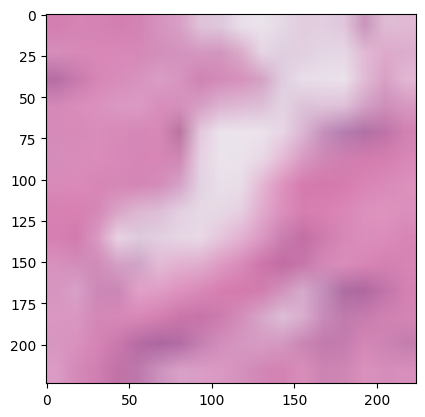

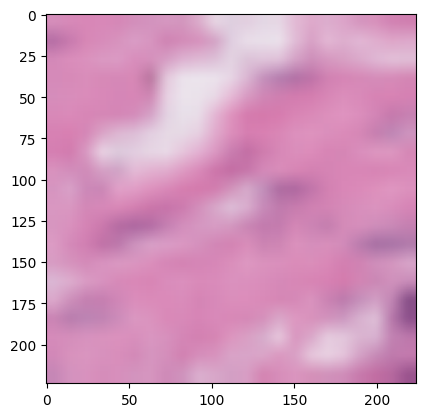

grad min tensor(-0.0002, device='cuda:0') grad max tensor(0.0002, device='cuda:0')
shape torch.Size([3, 224, 224])


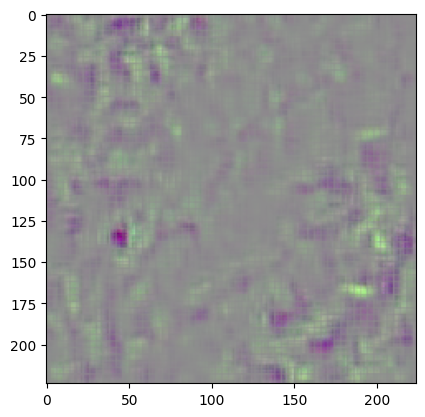

grad min tensor(-2.4830, device='cuda:0') grad max tensor(-0.2415, device='cuda:0')


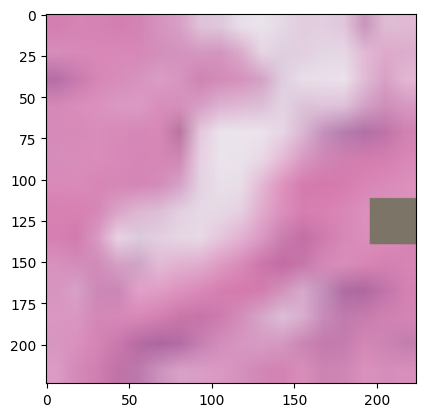

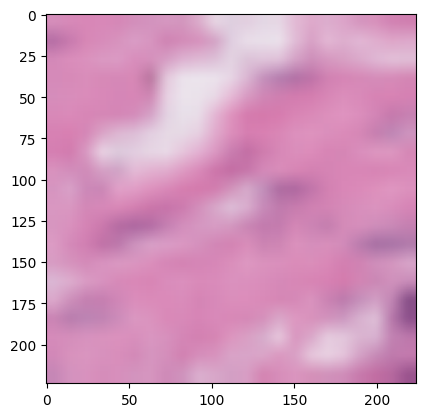

In [33]:
import matplotlib.pyplot as plt
import torchvision

model = torch.load(ROOT + "./attention_masking_moco/71101_epochs20_batch128_lr0.03_momentum0.9_moco-momentum0.999_loss-typeself_V2True.pickle")

def plt_show(img):
  mean=torch.tensor([0.485, 0.456, 0.406])
  std=torch.tensor([0.229, 0.224, 0.225])

  unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
  img = unnormalize(img)
  plt.imshow(img.permute((1,2,0)).cpu().detach().numpy())
  plt.show()

for images, labels in pretrain_loader:
  break

if args.loss_type == 'self':
  labels = None

# compute output
if args.gpu is not None:
    images[0] = images[0].cuda(args.gpu, non_blocking=True)
    images[1] = images[1].cuda(args.gpu, non_blocking=True)

# create attention pertubation
model.eval()
images[0] = images[0].clone().detach()
images[0].requires_grad = True

plt_show(images[0][0])
plt_show(images[1][0])


output, target = model(im_q=images[0], im_k=images[1], labels=labels)
loss = criterion(output, target)
loss.backward()

print("grad min", images[0].grad[0].min(), "grad max", images[0].grad[0].max())
g = ((images[0].grad[0] + images[0].grad[0].min()) / images[0].grad[0].max())
print("shape", g.shape)
plt.imshow(((g - g.min()) / (g.max() - g.min())).permute((1,2,0)).cpu().detach().numpy())
plt.show()
print("grad min", g.min(), "grad max", g.max(), )

images[0] = pert_func(images[0], images[0].grad, ATTENTION_INFO[1], ATTENTION_INFO[2])
images[0] = images[0].detach()
optimizer.zero_grad()

plt_show(images[0][0])
plt_show(images[1][0])

# compute output
model.train()
output, target = model(im_q=images[0], im_k=images[1], labels=labels)
loss = criterion(output, target)

# compute gradient and do SGD step
loss.backward()
optimizer.step()



In [ ]:
if args.gpu is not None:
  cudnn.benchmark = True

for epoch in range(args.start_epoch, args.epochs):
    adjust_learning_rate(optimizer, epoch, args)

    # train for one epoch
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('TrainLoss', ':.4e')
    # top1 = AverageMeter('Acc@1', ':6.2f')
    # top5 = AverageMeter('Acc@5', ':6.2f')
    val_losses = AverageMeter('ValLoss', ':.4e')
    # val_top1 = AverageMeter('ValAcc@1', ':6.2f')
    # val_top5 = AverageMeter('ValAcc@5', ':6.2f')
    progress = ProgressMeter(
        summary,
        len(pretrain_loader),
        # [batch_time, data_time, losses, top1, top5, val_losses, val_top1, val_top5],
        [batch_time, data_time, losses, val_losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    with tqdm.tqdm(pretrain_loader, unit="batch") as tepoch: 
      if WORKING_ENV == "LABS":
        tepoch = pretrain_loader
      for i, (images, labels) in enumerate(tepoch):
        # set label, if no label given, positive pair is image itself
        if args.loss_type == 'self':
          labels = None
        
        # measure data loading time
        data_time.update(time.time() - end)

        # compute output
        if args.gpu is not None:
            images[0] = images[0].cuda(args.gpu, non_blocking=True)
            images[1] = images[1].cuda(args.gpu, non_blocking=True)

        # create attention pertubation
        model.eval()
        images[0] = images[0].clone().detach()
        images[0].requires_grad = True

        output, target = model(im_q=images[0], im_k=images[1], labels=labels)
        loss = criterion(output, target)
        loss.backward()

        images[0] = pert_func(images[0], images[0].grad, ATTENTION_INFO[1], ATTENTION_INFO[2])
        images[0] = images[0].detach()
        optimizer.zero_grad()

        # compute output
        model.train()
        output, target = model(im_q=images[0], im_k=images[1], labels=labels)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()

        # update_accuracy_meters(losses, top1, top5, output, target, loss, images[0].size(0))
        losses.update(loss.item(), images[0].size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # log performance
        if i % args.print_freq == 0 and not i == 0:
          if WORKING_ENV == 'LABS':
            print(f"batch {i} loss: {loss.item()}")
          else:
            tepoch.set_description(f"batch {i}")
            tepoch.set_postfix(loss=loss.item())

          with torch.no_grad():
            model.eval()
            # evaluate on validation set
            for (images, labels) in pretrain_val_loader:
              if args.loss_type == 'self':
                labels = None
              if args.gpu is not None:
                images[0] = images[0].cuda(args.gpu, non_blocking=True)
                images[1] = images[1].cuda(args.gpu, non_blocking=True)
              output, target = model(im_q=images[0], im_k=images[1], labels=labels, train=False)
              loss = criterion(output, target)
              # update_accuracy_meters(val_losses, val_top1, val_top5, output, target, loss, images[0].size(0))
              val_losses.update(loss.item(), images[0].size(0))
            
            model.train()
          
          progress.display(i)


    # if not args.multiprocessing_distributed or (args.multiprocessing_distributed
    #         and args.rank % ngpus_per_node == 0):
    #     save_checkpoint({
    #         'epoch': epoch + 1,
    #         'arch': args.arch,
    #         'state_dict': model.state_dict(),
    #         'optimizer' : optimizer.state_dict(),
    #     }, is_best=False, filename='checkpoint_{:04d}.pth.tar'.format(epoch))



In [ ]:
torch.save(model, f"{slurm_id}_{trial_name}.pickle")
mem_report()

# Quantitative evaluation

In [ ]:
# model = torch.load(f"{trial_name}.pickle")


In [ ]:
model.eval()
eval_set_info = [("val_loader", val_loader, PROJ_HEAD_EPOCH_NUM * 8), ("pretrain_loader", pretrain_loader, PROJ_HEAD_EPOCH_NUM)]
for eval_loader_name, eval_loader, eval_epoch_num in eval_set_info:
    classification_head = nn.Linear(128, 9).cuda(args.gpu)
    head_optimizer = torch.optim.SGD(classification_head.parameters(), 0.05)
    ce_loss = nn.CrossEntropyLoss(reduction="mean")

    classification_head.train()
    for epoch in range(eval_epoch_num):
      with tqdm.tqdm(eval_loader, unit="batch") as tepoch: 
        for i, (images, labels) in enumerate(tepoch):
          images[0] = images[0].cuda(args.gpu, non_blocking=True)
          labels = labels.cuda(args.gpu, non_blocking=True)
          
          with torch.no_grad():
            q = model.encoder_q(images[0])  # queries: NxC
            q = nn.functional.normalize(q, dim=1)
          y_hat = classification_head(q)

          l = ce_loss(y_hat, labels.squeeze())

          head_optimizer.zero_grad()
          l.backward()
          head_optimizer.step()

          if i % 10 == 0 and not i == 0:
            summary.write(f"classification loss: {eval_loader_name}: epoch {epoch}[{i}]{l.item()}\n")

    classification_head.eval()
    acc_l = 0
    confusion_matrix = torch.zeros((9, 9))
    with torch.no_grad():
      for (img, label) in test_loader:
        img = img.cuda(args.gpu, non_blocking=True)
        label = label.cuda(args.gpu, non_blocking=True)

        q = model.encoder_q(img)
        q = nn.functional.normalize(q, dim=1)
        label_hat = classification_head(q)
        l = ce_loss(label_hat, label.squeeze())
                
        acc_l += l

        for i in range(label.shape[0]):
          confusion_matrix[label[i].item(), label_hat[i].argmax().item()] += 1

    acc_f1 = 0
    for i in range(confusion_matrix.shape[0]):
      recall = confusion_matrix[i, i] / confusion_matrix[i].sum()
      precision = confusion_matrix[i, i] / confusion_matrix[:, i].sum()
      acc_f1 += 2 / (1 / precision + 1 / recall)

    summary.write(f"test set loss: {acc_l / len(test_loader)}, macro F1: {acc_f1 / confusion_matrix.shape[0]}\n")
    summary.write("\n")

    torch.save(confusion_matrix, f"{slurm_id}_{trial_name}_{eval_loader_name}_confusion_matrix.pickle")
    torch.save(classification_head, f"{slurm_id}_{trial_name}_head_{eval_loader_name}.pickle")
      

In [ ]:
if WORKING_ENV == 'LABS':
  summary.close()

# Metric Evaluation

In [ ]:
import re
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE


/Users/xushitong/miniconda3/envs/med-contrast-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


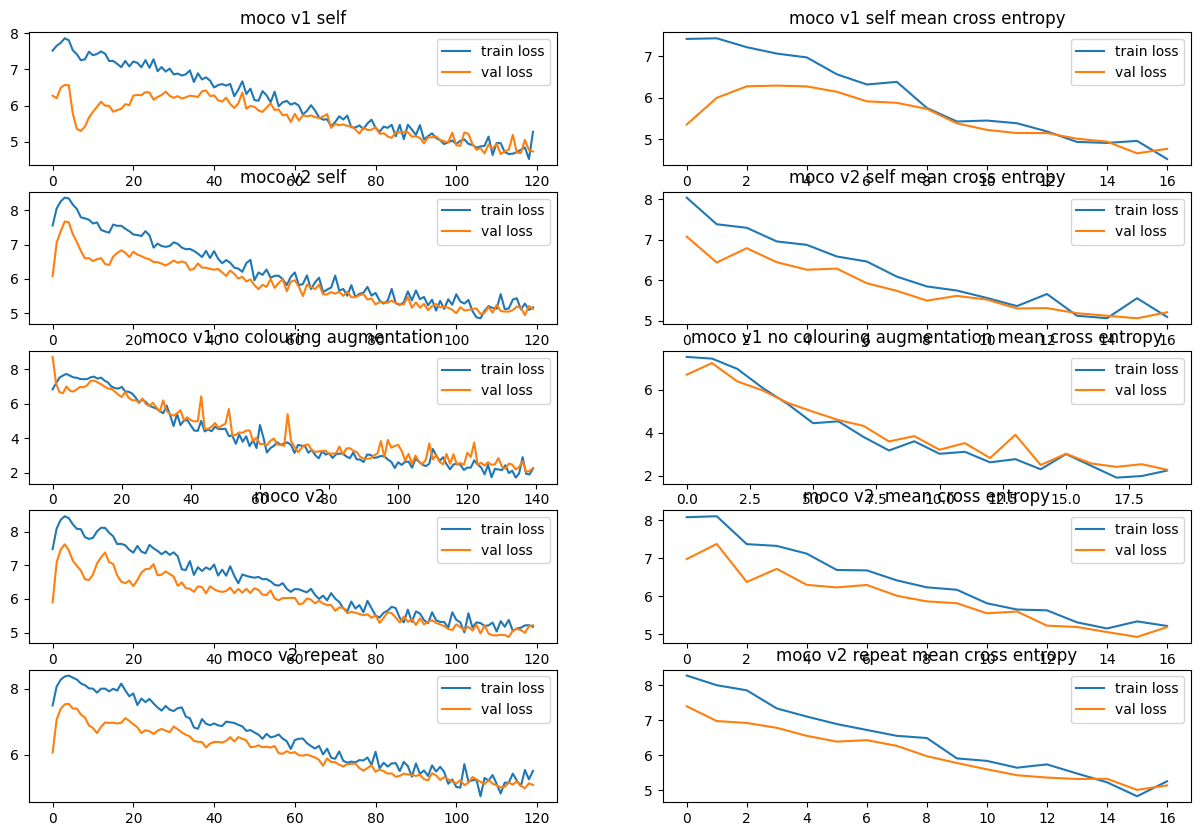

In [ ]:
def extract_float(file_name, start="Epoch"):
  def isfloat(word):
    try:
      float(word)
      return True
    except ValueError:
      return False
  file = open(file_name)
  l = [[float(word) for word in re.split("\n|,| |\t|\(|\)|\[|\]", line) if isfloat(word)] for line in file if line.startswith(start)]
  return torch.tensor(l)

# general propose plot
file_names = [
  "./epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2False_old.txt",
  "./epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True_old.txt", 
  "./epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2False_no-colouring_old.txt",  
  "./epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True.txt",
  "./70407_epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True.txt"
]
fig, axarr = plt.subplots(len(file_names), 2, figsize=(15, 10))
names = ["moco v1 self", "moco v2 self", "moco v1 no colouring augmentation", "moco v2 ", "moco v2 repeat"] # titles for each row of image, substitute of file name 
for i, file_name in enumerate(file_names):
  losses = extract_float(file_name) # shape [iteration_number * print num per iteration, 8], only loss at index [5, 7] are useful for plot
  train_index = {} # additional plot other than losses
  val_index = {}
  mean_loss_index = [i * 7 + 6 for i in range(losses.shape[0] // 7)]

  for j, idx in enumerate(train_index):
    axarr[i, j+1].plot(losses[:, idx])
  
  for j, idx in enumerate(val_index):
    axarr[i, j+1].plot(losses[:, idx])
    axarr[i, j+1].set_title(train_index[idx])

  axarr[i, 0].plot(losses[:, 5], label="train loss")
  axarr[i, 0].plot(losses[:, 7], label="val loss")
  axarr[i, 0].set_title(names[i])
  axarr[i, 0].legend(loc="upper right")


  axarr[i, -1].plot(losses[mean_loss_index, 5], label="train loss")
  axarr[i, -1].plot(losses[mean_loss_index, 7], label="val loss")
  axarr[i, -1].set_title(names[i] + " mean cross entropy")
  axarr[i, -1].legend(loc="upper right")


Text(0.5, 1.0, 'validation set projection perf.')

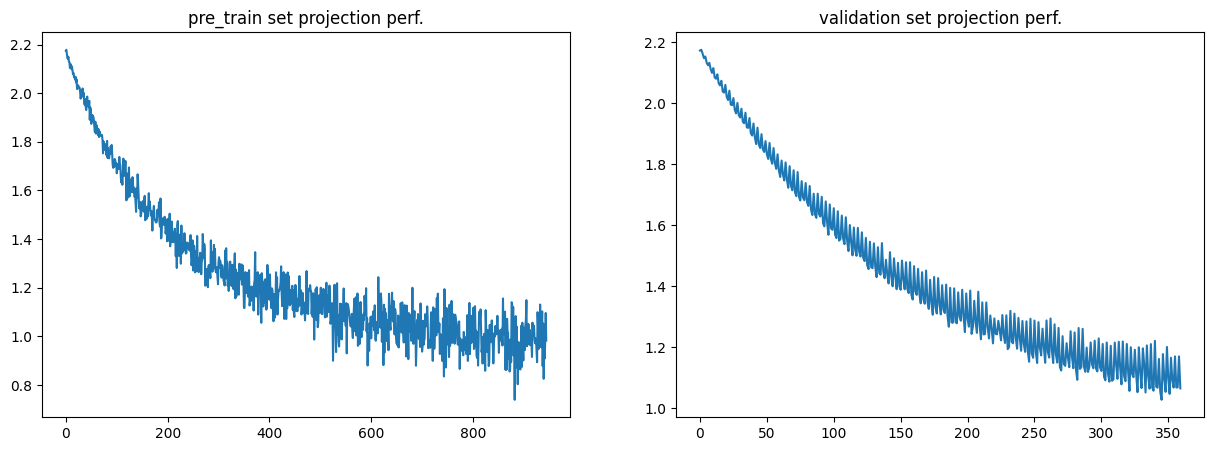

In [ ]:
file_name = "./70477_epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True.txt"
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
losses = extract_float(file_name, "classification loss: ")
axarr[0].plot(losses[:945, 2])
axarr[0].set_title("pre_train set projection perf.")
axarr[1].plot(losses[945:, 2])
axarr[1].set_title("validation set projection perf.")

In [ ]:
losses.shape

torch.Size([1305, 3])

In [ ]:
test_data = medmnist.PathMNIST("test", download=False, root=args.data, 
                                  #  transform=loader.TwoCropsTransform(transforms.Compose(augmentation)))
                                 transform=transforms.Compose([
                                  transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]))

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=512, shuffle=True, drop_last=True)
for x, y in test_loader:
  break

plot_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=512)
# plot_test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

evaluating epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True


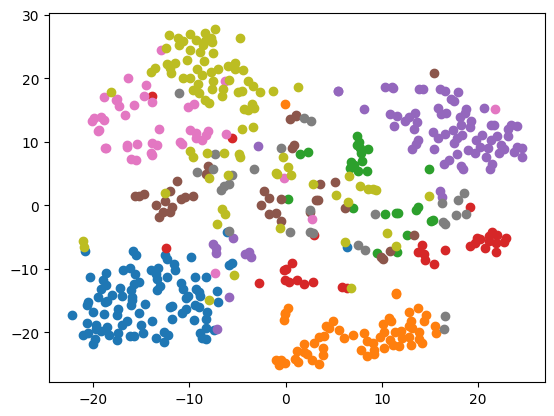

In [ ]:
eval_name = "epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True"
model = torch.load(ROOT + f"/moco/{eval_name}.pickle", map_location=torch.device('cpu') )
model.eval()
with torch.no_grad():
  embedding, _ = model(x, x, train=False)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embedding)

cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(f"evaluating f{eval_name}")
for i in range(0, y.max()+1):
  plt.scatter(z_embedded[(y == i).squeeze(), 0], z_embedded[(y == i).squeeze(), 1], c=cs[i])


evaluating fepochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2False


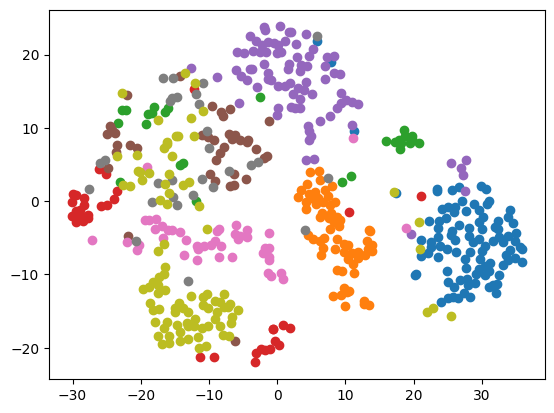

In [ ]:
eval_name = "epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2False"
model = torch.load(ROOT + f"/moco/{eval_name}.pickle", map_location=torch.device('cpu') )
model.eval()
with torch.no_grad():
  embedding, _ = model(x, x, train=False)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embedding)

cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(f"evaluating f{eval_name}")
for i in range(0, y.max()+1):
  plt.scatter(z_embedded[(y == i).squeeze(), 0], z_embedded[(y == i).squeeze(), 1], c=cs[i])


In [ ]:
x = torch.randn((2,3))
y = torch.tensor([[1,0,1],[0, 1, 0]], dtype=torch.float32)

((x.exp() / x.exp().sum(dim=-1, keepdim=True)).log() * y).sum(dim=-1).mean(), nn.CrossEntropyLoss(reduction="mean")(x, y)

(tensor(-2.5201), tensor(2.5201))

In [ ]:
x = torch.randn((2,3))
y = torch.tensor([[1,0,1],[0, 1, 0]], dtype=torch.float32)
l = nn.BCEWithLogitsLoss()
sig = (1 / (1 + (-x).exp()))

(-(1 - y) * (1 - sig).log() - y * sig.log()).mean(), nn.functional.binary_cross_entropy_with_logits(x, y)

(tensor(0.9606), tensor(0.9606))